In [1]:
import csv
import numpy as np

images, labels = [], []

with open('train.csv') as train_file:
    # Skip first line.
    train_file.readline()
    
    csv_train_file = csv.reader(train_file, delimiter=',')
    for row in csv_train_file:
        labels.append(row[0])
        images.append(np.array(row[1:], dtype=float))

Printing sample with label 8.


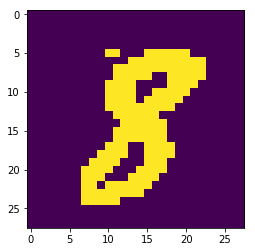

In [2]:
sample_index = 20

import matplotlib
from matplotlib import pyplot as plt

sample, label = images[sample_index], labels[sample_index]
plt.imshow(np.reshape(sample, (28, 28)), norm=matplotlib.colors.NoNorm())

print("Printing sample with label %s." % (label))
plt.show()

Printing sample with normalzied pixels.


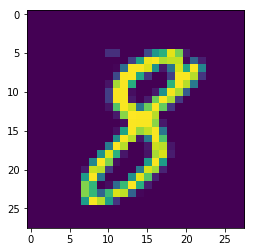

In [3]:
# Normalizing a sample to scale of (0, 1)

PIXEL_SCALE = 255

normalized_sample = sample / PIXEL_SCALE
plt.imshow(np.reshape(normalized_sample, (28, 28)), norm=matplotlib.colors.NoNorm())
print("Printing sample with normalzied pixels.")
plt.show()

In [4]:
normalized_images = [image / PIXEL_SCALE for image in images]

In [5]:
# One hot encoding labels.
def one_hot_label(label):
    one_hot_coded = np.zeros(10)
    one_hot_coded[int(label)] = 1
    return one_hot_coded

In [6]:
one_hot_labels = list(map(one_hot_label, labels))

In [7]:
def conv_net_input(input_shape):
    tensor_shape = [None] + list(input_shape)
    return tf.placeholder(tf.float32, shape=tensor_shape, name='conv_input')

def conv_net_label(label_shape):
    label_shape = [None] + list(label_shape)
    return tf.placeholder(tf.float32, shape=label_shape, name='conv_label')

def conv_net_keep_prob():
    return tf.placeholder(tf.float32, name='keep_prob')

In [8]:
def conv2d(input_tensor, output_dim, k_size, padding='valid'):
    """
    :param input_tensor: input tensor, should be reshaped to 2D
    :param output_dim: output dimension, e.g. 32, 64, etc.
    :param kernel_size: kernel size, 3, 5, etc.
    """
    kernel_size = (k_size, k_size)
    
    kernel_initializer = tf.Variable((kernel_size, kernel_size), mean=0, stddev=0.1, dtype=tf.float32)
    conv_layer = tf.layers.conv2d(input_tensor,
                                  output_dim,
                                  kernel_size,
                                  padding,
                                  kernel_initializer=kernel_initializer,
                                  activation=tf.nn.relu)
    # use_bias=True, bias_initializer=tf.zeros_initializer()
    
    return tf.nn.relu(conv_layer)

In [9]:
def max_pool(input_tensor, pool_ksize, pool_strides, padding='valid'):
    return tf.layers.max_pooling2d(
        input_tensor,
        pool_ksize,
        pool_strides,
        padding
    )

In [12]:
def fully_connected(input_tensor, output_dim):
    return tf.layers.fully_connected(
        input_tensor,
        output_dim
    )